# 🚀 FunctionGemma 交互式训练 Notebook

本 Notebook 提供可视化的模型微调环境，支持：
- 📊 实时训练指标可视化
- 🎯 交互式参数配置
- 📈 Loss 曲线动态绘制
- 🔍 训练样本质量检查
- 💾 模型导出与推理测试

## 1. 环境初始化

In [1]:
import os
# 设置 HF_ENDPOINT 环境变量
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

import os
os.environ["HF_DATASETS_DISABLE_MULTIPROCESSING"] = "1"

# 检查 GPU 可用性
import torch
import sys
from pathlib import Path

# 添加项目根目录到路径
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

print(f"🔥 PyTorch 版本: {torch.__version__}")
print(f"🎮 CUDA 可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"📺 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU 显存: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ 警告: 未检测到 GPU，训练将非常慢")

🔥 PyTorch 版本: 2.10.0+cu128
🎮 CUDA 可用: True
📺 GPU: NVIDIA GeForce RTX 3080 Ti
💾 GPU 显存: 12.50 GB


## 2. 导入依赖

In [2]:
import json
import logging
from datetime import datetime
from typing import Optional, List, Dict, Any

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output
from tqdm.notebook import tqdm
import ipywidgets as widgets

# 项目模块
from src.utils.config_loader import load_config, print_config
from src.data_engine.converter import DataConverter
from src.data_engine.formatter import FunctionGemmaFormatter
from src.training.trainer import FunctionGemmaTrainer
from src.training.callbacks import (
    WandbCallback,
    SampleGenerationCallback,
    EarlyStoppingCallback
)

# 设置日志
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

print("✅ 所有依赖导入成功！")

/home/ubuntu/SiNan/src/training/trainer.py:24: UserWarning: WARNING: Unsloth should be imported before [trl, transformers, peft] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel, is_bfloat16_supported


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
✅ 所有依赖导入成功！


## 3. 交互式参数配置

使用下面的控件配置训练参数：

In [3]:
# 创建交互式配置控件
config_widgets = {
    'model_name': widgets.Text(
        value='google/functiongemma-270m-it',
        description='模型名称:',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='500px')
    ),
    'max_seq_length': widgets.IntSlider(
        value=2048, min=512, max=8192, step=512,
        description='最大序列长度:',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='500px')
    ),
    'lora_rank': widgets.IntSlider(
        value=16, min=4, max=64, step=4,
        description='LoRA Rank:',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='500px')
    ),
    'lora_alpha': widgets.IntSlider(
        value=16, min=4, max=64, step=4,
        description='LoRA Alpha:',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='500px')
    ),
    'epochs': widgets.IntSlider(
        value=3, min=1, max=10, step=1,
        description='训练轮数:',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='500px')
    ),
    'batch_size': widgets.IntSlider(
        value=4, min=1, max=16, step=1,
        description='Batch Size:',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='500px')
    ),
    'learning_rate': widgets.FloatLogSlider(
        value=2e-4, base=10, min=-5, max=-3, step=0.1,
        description='学习率:',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='500px')
    ),
    'gradient_accumulation': widgets.IntSlider(
        value=4, min=1, max=16, step=1,
        description='梯度累积:',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='500px')
    ),
    'data_path': widgets.Text(
        value='/home/ubuntu/SiNan/demo/training_demo/demo_functions.jsonl',
        description='数据路径:',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='500px')
    ),
    'output_dir': widgets.Text(
        value=f'outputs/models/experiment_{datetime.now().strftime("%Y%m%d_%H%M%S")}',
        description='输出目录:',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='500px')
    ),
}

# 显示配置控件
print("🎛️ 训练参数配置")
print("=" * 50)
for widget in config_widgets.values():
    display(widget)

🎛️ 训练参数配置


Text(value='google/functiongemma-270m-it', description='模型名称:', layout=Layout(width='500px'), style=TextStyle(…

IntSlider(value=2048, description='最大序列长度:', layout=Layout(width='500px'), max=8192, min=512, step=512, style=…

IntSlider(value=16, description='LoRA Rank:', layout=Layout(width='500px'), max=64, min=4, step=4, style=Slide…

IntSlider(value=16, description='LoRA Alpha:', layout=Layout(width='500px'), max=64, min=4, step=4, style=Slid…

IntSlider(value=3, description='训练轮数:', layout=Layout(width='500px'), max=10, min=1, style=SliderStyle(descrip…

IntSlider(value=4, description='Batch Size:', layout=Layout(width='500px'), max=16, min=1, style=SliderStyle(d…

FloatLogSlider(value=0.0002, description='学习率:', layout=Layout(width='500px'), max=-3.0, min=-5.0, style=Slide…

IntSlider(value=4, description='梯度累积:', layout=Layout(width='500px'), max=16, min=1, style=SliderStyle(descrip…

Text(value='/home/ubuntu/SiNan/demo/training_demo/demo_functions.jsonl', description='数据路径:', layout=Layout(wi…

Text(value='outputs/models/experiment_20260225_005118', description='输出目录:', layout=Layout(width='500px'), sty…

## 4. 数据加载与可视化

In [4]:
def load_and_visualize_data(data_path: str):
    data_path = Path(data_path)

    if not data_path.exists():
        print(f"⚠️ 数据文件不存在: {data_path}")
        print("正在创建示例数据...")
        create_sample_data(data_path)

    converter = DataConverter()
    dataset = converter.load_dataset(str(data_path))
    df = pd.DataFrame(dataset)

    print(f"\n📊 数据概览")
    print(f"总样本数: {len(df)}")
    print(f"列名: {list(df.columns)}")

    print("\n📋 前 3 条样本:")
    for i in range(min(3, len(df))):
        print(f"\n样本 {i+1}:")
        for col in df.columns:
            value = df.iloc[i][col]
            if isinstance(value, str) and len(value) > 200:
                value = value[:200] + "..."
            print(f"  {col}: {value}")

    return dataset, df

def create_sample_data(output_path: Path):
    output_path.parent.mkdir(parents=True, exist_ok=True)

    sample_data = [
        {"text": "Sample training text 1"},
        {"text": "Sample training text 2"},
        {"text": "Sample training text 3"},
    ]

    expanded_data = []
    for i in range(100):
        for sample in sample_data:
            expanded_data.append(sample)

    with open(output_path, 'w', encoding='utf-8') as f:
        for item in expanded_data:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')

    print(f"✅ 已创建示例数据: {output_path}")

# 加载数据
data_path = config_widgets['data_path'].value
dataset, df = load_and_visualize_data(data_path)


📊 数据概览
总样本数: 1746
列名: ['user_content', 'tool_name', 'tool_arguments']

📋 前 3 条样本:

样本 1:
  user_content: 京A12345这个车牌好吗
  tool_name: get_license_plate_value
  tool_arguments: {"che": "京A12345"}

样本 2:
  user_content: 查下今天的农历
  tool_name: get_lunar_calendar
  tool_arguments: {"type": "json"}

样本 3:
  user_content: 普吉岛今天几度
  tool_name: get_current_temperature
  tool_arguments: {"location": "普吉岛"}


## 5. 数据统计分析

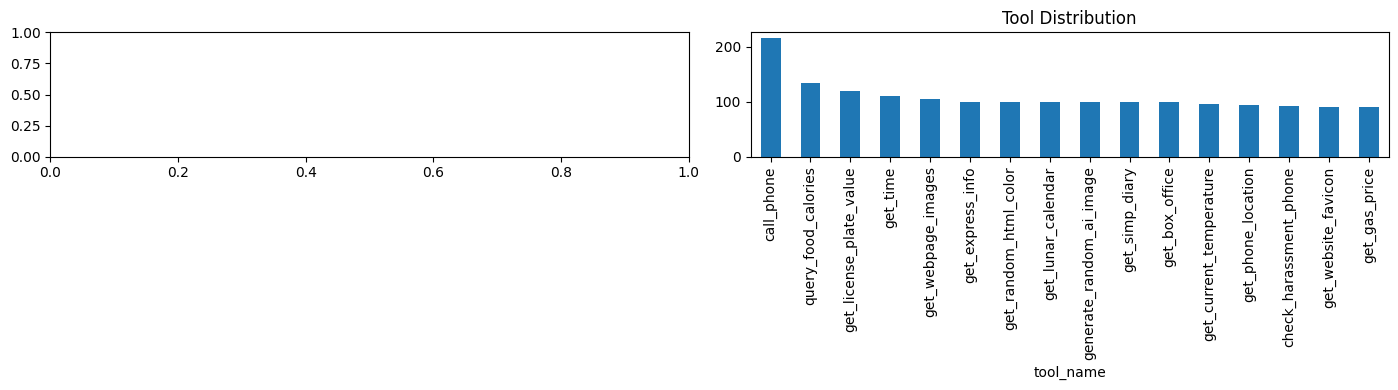


📈 数据统计


In [5]:
# 数据统计可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

if 'text' in df.columns:
    text_lengths = df['text'].str.len()
    axes[0].hist(text_lengths, bins=30, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Text Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Text Length')
    axes[0].axvline(text_lengths.mean(), color='red', linestyle='--')

if 'tool_name' in df.columns:
    tool_counts = df['tool_name'].value_counts()
    tool_counts.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Tool Distribution')

plt.tight_layout()
plt.show()

print("\n📈 数据统计")
print("=" * 50)

## 6. 训练可视化回调类

In [6]:
from transformers import TrainerCallback
from collections import defaultdict

class JupyterVisualizationCallback(TrainerCallback):
    def __init__(self, update_steps: int = 10):
        super().__init__()
        self.update_steps = update_steps
        self.metrics_history = defaultdict(list)
        self.fig = None
        self.axes = None

    def setup_plot(self):
        plt.ion()
        self.fig, self.axes = plt.subplots(2, 2, figsize=(14, 10))
        self.fig.suptitle('Training Metrics (Real-time)', fontsize=14)
        plt.show()

    def on_train_begin(self, args, state, control, **kwargs):
        print("\n🚀 训练开始！")
        self.setup_plot()

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return
        step = state.global_step
        for key, value in logs.items():
            if isinstance(value, (int, float)):
                self.metrics_history[key].append((step, value))
        if step % self.update_steps == 0:
            self.update_plots()

    def update_plots(self):
        if self.axes is None:
            return
        for ax in self.axes.flat:
            ax.clear()

        if 'loss' in self.metrics_history:
            steps, losses = zip(*self.metrics_history['loss'])
            self.axes[0, 0].plot(steps, losses, 'b-', linewidth=2)
            self.axes[0, 0].set_title('Training Loss')
            self.axes[0, 0].grid(True, alpha=0.3)

        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        plt.pause(0.01)

    def on_train_end(self, args, state, control, **kwargs):
        print("\n✅ 训练完成！")
        plt.ioff()
        plt.savefig('training_metrics.png', dpi=150)

print("✅ 可视化回调类已定义")

✅ 可视化回调类已定义


## 7. 开始训练

运行下面的单元格开始训练：

In [7]:
from omegaconf import OmegaConf

config_dict = {
    'model': {
        'name': config_widgets['model_name'].value,
        'max_seq_length': config_widgets['max_seq_length'].value,
        'dtype': 'bfloat16',
        'lora': {
            'enabled': True,
            'rank': config_widgets['lora_rank'].value,
            'alpha': config_widgets['lora_alpha'].value,
            'target_modules': ["q_proj", "k_proj", "v_proj"],
        },
    },
    'training': {
        'epochs': config_widgets['epochs'].value,
        'per_device_train_batch_size': config_widgets['batch_size'].value,
        'learning_rate': config_widgets['learning_rate'].value,
    },
    'logging': {
        'output_dir': config_widgets['output_dir'].value,
        'wandb': {'enabled': False}
    }
}

config = OmegaConf.create(config_dict)
print("🔧 训练配置")
print(OmegaConf.to_yaml(config))

🔧 训练配置
model:
  name: google/functiongemma-270m-it
  max_seq_length: 2048
  dtype: bfloat16
  lora:
    enabled: true
    rank: 16
    alpha: 16
    target_modules:
    - q_proj
    - k_proj
    - v_proj
training:
  epochs: 3
  per_device_train_batch_size: 4
  learning_rate: 0.0002
logging:
  output_dir: outputs/models/experiment_20260225_005118
  wandb:
    enabled: false




📥 加载模型...
==((====))==  Unsloth 2026.2.1: Fast Gemma3 patching. Transformers: 4.57.6.
   \\   /|    NVIDIA GeForce RTX 3080 Ti. Num GPUs = 1. Max memory: 11.642 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.35. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.
Unsloth: Making `model.base_model.model.model` require gradients
✅ 模型加载完成

🎯 开始训练...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 5,232 | Num Epochs = 9,223,372,036,854,775,807 | Total steps = 327
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 995,328 of 269,093,504 (0.37% trained)
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/ubuntu/.netrc.
wandb: Currently logged in as: laurence to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/



🚀 训练开始！


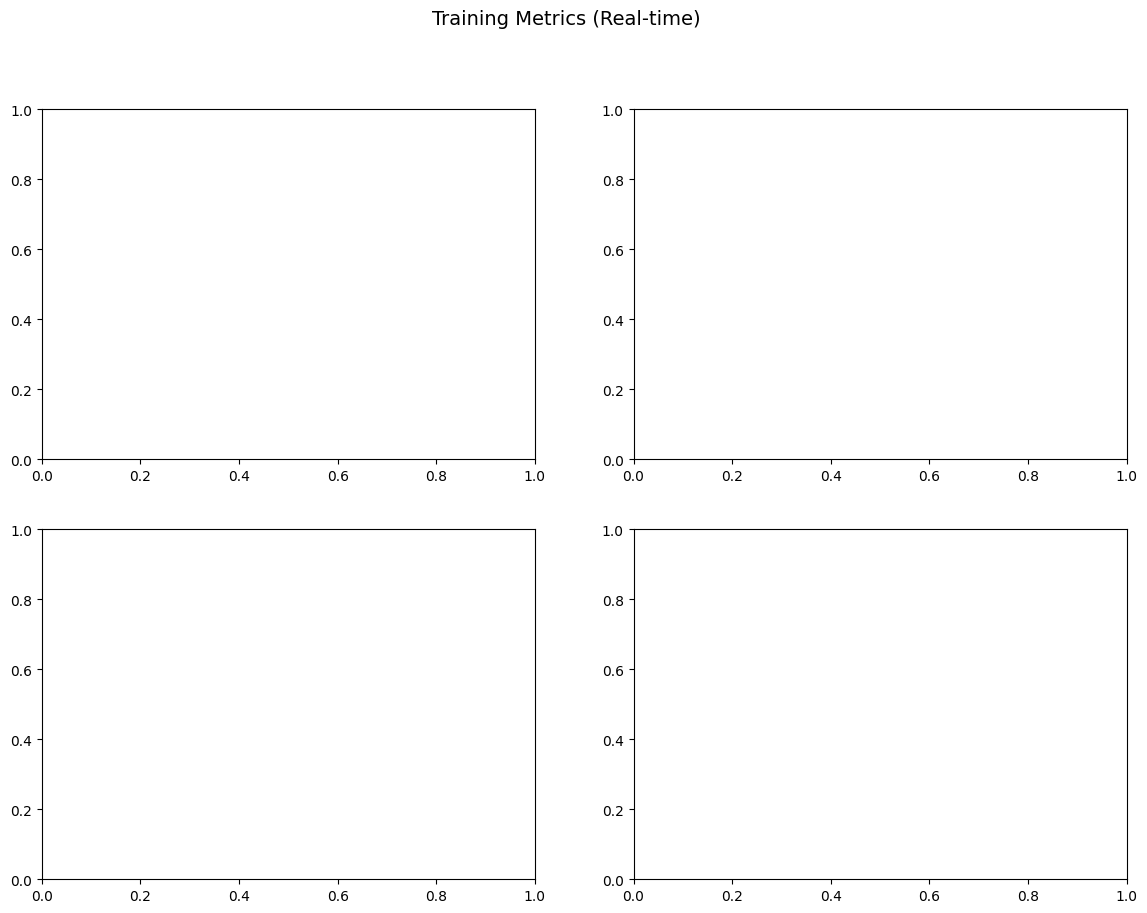

[liger_kernel.transformers.model.gemma3|WARNING]It is strongly recommended to train Gemma3 models with the `eager` attention implementation instead of `flex_attention`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.


Step,Training Loss
10,5.089600
20,3.736200
30,2.975900
40,2.486200
50,2.201500
60,1.949600
70,1.765600
80,1.730300
90,1.648700
100,1.588500



✅ 训练完成！

✅ 训练完成！


<Figure size 640x480 with 0 Axes>

In [8]:
# 创建训练器
trainer = FunctionGemmaTrainer(config)

print("\n📥 加载模型...")
trainer.load_model()
print("✅ 模型加载完成")

callbacks = [JupyterVisualizationCallback(update_steps=5)]

print("\n🎯 开始训练...")
train_result = trainer.train(
    train_dataset=dataset,
    output_dir=config.logging.output_dir,
    callbacks=callbacks
)
print(f"\n✅ 训练完成！")

## 8. 保存模型

In [9]:
output_dir = config.logging.output_dir
Path(output_dir).mkdir(parents=True, exist_ok=True)

print(f"💾 保存模型到: {output_dir}")
trainer.save_model(output_dir)

config_save_path = Path(output_dir) / 'training_config.yaml'
OmegaConf.save(config, config_save_path)
print(f"✅ 配置已保存")

💾 保存模型到: outputs/models/experiment_20260225_005118


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


✅ 配置已保存


## 9. 推理测试

In [10]:
# 交互式推理
inference_widget = widgets.Textarea(
    value='查询北京天气',
    description='输入:',
    layout=widgets.Layout(width='100%', height='80px')
)

run_button = widgets.Button(
    description='运行推理',
    button_style='success',
    icon='play'
)

output_area = widgets.Output()

def on_run_button_clicked(b):
    with output_area:
        clear_output()
        print("🤖 正在推理...\n")
        prompt = inference_widget.value
        try:
            result = trainer.inference(prompt, max_new_tokens=128)
            print(f"输入: {prompt}\n")
            print(f"输出: {result}")
        except Exception as e:
            print(f"❌ 推理失败: {e}")

run_button.on_click(on_run_button_clicked)

display(widgets.VBox([
    widgets.HTML("<h3>🎯 模型推理测试</h3>"),
    inference_widget,
    run_button,
    output_area
]))

## 10. 批量推理测试

In [11]:
test_prompts = [
    "查询北京天气",
    "把背景改成蓝色",
    "创建一个名字叫张三的用户",
]

print("🧪 批量推理测试\n")
for i, prompt in enumerate(test_prompts, 1):
    print(f"\n测试 {i}/{len(test_prompts)}")
    result = trainer.inference(prompt)
    print(f"输入: {prompt}")
    print(f"输出: {result[:200]}...")
    print("-" * 60)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


🧪 批量推理测试


测试 1/3


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


输入: 查询北京天气
输出: 查询北京天气
Tool: get_current_temperature
Args: {"location": "北京"} Pusenkoff pls_send_email_temperature_1000 Bestellung gönder ici", "]</div>"}matchCondition_free_phone_area_temp图"}chartsetails":{"type":"t...
------------------------------------------------------------

测试 2/3


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


输入: 把背景改成蓝色
输出: 把背景改成蓝色
Tool: get_random_html_color
Args: {"type": "light"}<unused4001>:tg4433388600", "url": "get_random_html_color"}updateConfirm4000100000"铃APhone1234567890"}retrieve20210000000铃APhone1234567890"To...
------------------------------------------------------------

测试 3/3
输入: 创建一个名字叫张三的用户
输出: 创建一个名字叫张三的用户
Tool: get_random_alive_name
Args: {"name": "张三"}CxxInterop:CFKKKGKGKGKGKK图",اكمьте":true,"]}数据图查询结果"}uniya今天天气"}chuyaKOKTFYI今天今天温度"}chuyaKOKTFYI今天温度图结果"}chuyaKOKTFYI今天温度图结果repeat303212345...
------------------------------------------------------------


## 11. 模型导出

In [12]:
from src.utils.export import export_model

export_format = widgets.Dropdown(
    options=['pytorch', 'gguf'],
    value='pytorch',
    description='格式:'
)

export_button = widgets.Button(
    description='导出模型',
    button_style='primary'
)

export_output = widgets.Output()

def on_export_clicked(b):
    with export_output:
        clear_output()
        print(f"📦 导出模型...")

export_button.on_click(on_export_clicked)

display(widgets.VBox([
    widgets.HTML("<h3>📦 模型导出</h3>"),
    export_format,
    export_button,
    export_output
]))